# ニューラルネットワークの復習  
前作のダイジェスト

## まとめ
- ベクトルや行列の復習
- ニューラルネットワークの仕組み
   - 入力層，隠れ層，出力層を持つ
   - 計算グラフの基本パーツ
       - 加算ノード
       - 乗算ノード
       - Repeatノード
       - Sumノード
       - MatMulノード
   - 順伝播と逆伝播
- ニューラルネットワークの実装
    - レイヤ(NNの組み立てが容易になる)
        - Affineレイヤ(全結合層)
        - Sigmoidレイヤ(活性化関数,非線形な変換を可能にする)
        - SoftmaxWithLossレイヤ
        - forward()とbackward()を持つ
        - paramsとgradsを持つ
    - ミニバッチ処理で行列としてまとめて計算
    - 誤差逆伝播法で効率的にNNの損失に関する勾配を求めることができる．
- スパイラルデータセット
    - 二層NNで学習
- 高速化
    - ビット精度を32にする
    - GPUによる並列計算はnumpyと同じインタフェースを持つcupyで簡単に行える．

In [42]:
%matplotlib inline

## 数学とPython

一般的にベクトルは列ベクトルであらわされるが，本書では実装上の問題から行ベクトルを使う．  

In [2]:
import numpy as np

x = np.array([1,2,3])
print(x.__class__)
print(x.shape)
print(x.ndim)

<class 'numpy.ndarray'>
(3,)
1


In [3]:
# 1次元目は行ベクトル！
W = np.array([[1,3,5], [2,4,6]])
print(W.shape)
print(W.ndim)

(2, 3)
2


In [4]:
# 行列同士の演算
W = np.array([[1,2,3], [4,5,6]])
X = np.array([[0,1,2], [3,4,5]])
print(W + X)
print(W * X)

[[ 1  3  5]
 [ 7  9 11]]
[[ 0  2  6]
 [12 20 30]]


In [5]:
# スカラーによる演算  
A = np.array([[1,2], [3,4]])
print(A * 10)

b = np.array([10, 20])
print(A * b) #bの2行目を拡張する

[[10 20]
 [30 40]]
[[10 40]
 [30 80]]


In [6]:
# ベクトルの内積
a = np.array([1,2,3])
b = np.array([4,5,6])
np.dot(a, b)

32

In [7]:
# 行列の積
A = np.array([[1,2], [3,4]])
B = np.array([[5,6], [7,8]])
A@B # np.dot(A, B)

array([[19, 22],
       [43, 50]])

[Numpy100](https://github.com/rougier/numpy-100)

## ニューラルネットワークの推論  
NNは単なる関数  
NN： ニューロンが矢印でつながり，その矢印に重み，ニューロンの出力にバイアスがかかり，入力層，中間層，出力層がある計算モデル  
重みのある層の数がNNの層の数．入力層には重みがなかったりするので，3列見えるNNは2層NN

In [8]:
# 1つのサンプルデータ
N = 1
W1 = np.random.rand(2, 4)
x = np.random.rand(N, 2)
b1 = np.random.rand(4)

h = x @ W1 + b1
print(h)

# 複数のサンプルデータを一度に処理(バッチ処理)
N = 10
x = np.random.rand(N, 2)
h = x @ W1 + b1
print(h)

[[0.75965065 1.85505798 1.09705565 0.95164566]]
[[0.7770675  1.61294223 0.96598291 0.74216491]
 [0.64528626 1.55028208 0.81006987 0.78605446]
 [0.82782417 1.65693875 1.03806588 0.74141713]
 [0.67321983 1.65914503 0.90101711 0.85449943]
 [0.67167192 1.58219319 0.85301775 0.79301887]
 [0.59630574 1.41544014 0.68454679 0.71162753]
 [0.64167014 1.37305241 0.69947563 0.64449387]
 [0.7030545  1.4425782  0.79653582 0.65686226]
 [0.70701733 1.73432766 0.97681114 0.89132688]
 [0.5731665  1.25278516 0.56530622 0.59597557]]


全結合層による変換は「線形」  
活性化関数によって「非線形」な効果を与えられる．

In [9]:
# シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# hのすべての要素にシグモイド関数を適用
sigmoid(h)

array([[0.68504775, 0.83381948, 0.72431808, 0.67746908],
       [0.65594745, 0.82495447, 0.69212439, 0.68698352],
       [0.69589467, 0.83982664, 0.73847664, 0.67730567],
       [0.66222376, 0.8401232 , 0.71115847, 0.70151015],
       [0.66187743, 0.8295149 , 0.7011998 , 0.68847917],
       [0.64481066, 0.80462258, 0.66475274, 0.67076068],
       [0.6551309 , 0.79787287, 0.6680715 , 0.6557686 ],
       [0.66886465, 0.80885358, 0.68923297, 0.65855519],
       [0.66974176, 0.84996514, 0.72647502, 0.70916392],
       [0.63949351, 0.77778161, 0.63767941, 0.64473504]])

In [10]:
# ニューラルネットワークの推論フェーズのまとめ
# 2 - 4 - 3 ネットワークを作成
batch_N = 10

x = np.random.randn(batch_N, 2)
W1 = np.random.randn(2, 4)
b1 = np.random.randn(4)
W2 = np.random.randn(4, 3)
b2 = np.random.randn(3)

h = x @ W1 + b1
a = sigmoid(h)
s = a @ W2 + b2

print(s)

# 各バッチで入力がどのクラスになるかは，スコアの最も高いものを選ぶことになる．
# これらのスコアをSoftmax関数に入れると，クラスに入る確率を得られる．
np.max(s, axis=1)

[[-0.04868122  0.90814017 -0.74869488]
 [ 0.16619621  1.05939697 -0.86320553]
 [ 0.72129884  1.50021077 -0.8247134 ]
 [ 0.74002374  1.4712796  -0.73776379]
 [-0.1579412   0.83857922 -0.72086922]
 [ 0.85509016  1.49368013 -0.22471231]
 [-0.83934288  0.3706292  -0.7295603 ]
 [-0.33130505  0.74703904 -1.08541543]
 [ 0.24835515  1.09915255 -0.6871742 ]
 [-0.39758075  0.69234765 -0.88360119]]


array([0.90814017, 1.05939697, 1.50021077, 1.4712796 , 0.83857922,
       1.49368013, 0.3706292 , 0.74703904, 1.09915255, 0.69234765])

### レイヤのクラス化  
sigmoidレイヤとAffineレイヤをクラスとして作成

実装ルール
- 全てのレイヤはメソッドとしてforward(input_params)とbackward(dout)を持つ
- 全てのレイヤはインスタンス変数としてparamsとgradsを持つ

In [11]:
class Sigmoid:
    def __init__(self):
        self.params = []
    
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

In [12]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
    
    def forward(self, x):
        W, b = self.params
        return x @ W + b

SigmoidレイヤとAffineレイヤを使って2層NNを作成  
x -> Affine -> Sigmoid -> Affine -> S

In [13]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        
        # 重みとバイアスの初期化
        W1 = np.random.randn(input_size, hidden_size)
        b1 = np.random.randn(hidden_size)
        W2 = np.random.randn(hidden_size, output_size)
        b2 = np.random.randn(output_size)
        
        # レイヤを作成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        
        # 全ての重みをリストにまとめる
        # レイヤレベルではなく，ネットワークレベルでparamsを持つことで，
        # パラメータの更新，保存を簡単にする
        self.params = []
        for layer in self.layers:
            self.params += layer.params # リストとリストでは+=演算子は結合になる
        
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

In [14]:
# TwoLayerNetで推論（順伝搬）
x = np.random.randn(10, 2)
model = TwoLayerNet(2,4,3)
model.predict(x)

array([[1.25244504, 0.72573324, 3.3192245 ],
       [1.22386255, 0.98945283, 2.88645391],
       [0.94547232, 0.41392285, 4.16786365],
       [1.33974503, 0.13820757, 3.43594745],
       [1.18446599, 0.51124699, 3.58219008],
       [1.14599858, 1.10306275, 2.98433438],
       [1.25252392, 0.8376773 , 3.23480089],
       [1.37608805, 0.46548387, 3.20961407],
       [1.17480378, 1.04053379, 2.88435185],
       [0.87651558, 1.05086192, 3.94296298]])

## ニューラルネットワークの学習  
学習： 多クラス分類などの問題の答えを正確に導けるようになるため，パラメータを更新する作業  

### 損失関数  
#### 交差エントロピー誤差
- 多クラス分類問題に利用
- Softmaxの出力となる確率と教師ラベルを比べる  
Softmax関数は以下であらわされる
$$ y_k= \frac{exp(s_k)}{\sum_{i=1}^{n}exp(s_i)} $$
全てのSoftmaxの出力のうち，k番目の出力がどれだけの割合を持つか．比較するときはexpをかませる
  
交差エントロピー誤差は以下であらわされる
$$ L = -\sum_{k}t_k logy_k $$
tは教師ラベル．one-hotなので，実質正解ラベルが1の要素に対応する出力の自然対数を計算するだけ．  
ミニバッチ処理では以下の式で，平均の交差エントロピー誤差を求める．
$$ L = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}log y_{nk} $$
本書ではSoftmax with Loss レイヤとして一つにまとめる．

In [15]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

### 微分と勾配
損失をなるべく小さくするパラメータを見つけるために，関数の微分，勾配を使う  
$y=x^2$の微分は$\frac{dy}{dx} = 2x$であり，xの値を少しだけ変化させたときの変化量であり，点$x$における傾きである．  
多変数についての微分も求められる．  
ベクトル内の変数に関する微分と，ベクトルに対する微分が定義される．  
それらのベクトルの各要素に関する微分をまとめてベクトルとしたものを勾配と呼ぶ．  
行列に関する微分も，各要素を各変数で微分することで定義できる．  

### チェインルール
各パラメータに関する損失の勾配を求め，勾配が小さくなる方向に変数を変化させていく．  
ニューラルネットワークの勾配は誤差逆伝搬法を用いて求める．  
誤差逆伝搬法を理解するうえで，チェインルール（合成関数の微分法）が出てくる．  
$ z = g(f(x))$の微分は$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$と，内側と外側の積であらわせる．  
これによって，我々の扱う関数がどんなに複雑でも，局所的な微分の組み合わせで全体の微分を求めることができる．

### 計算グラフ
計算グラフは，演算をノード，値をエッジとしたグラフである．  
順方向への計算を通常の計算，$\frac{\partial L}{\partial z}$を出力側に入力して逆方向へ伝搬させると勾配を求めることになる．  
加算ノードであれば，計算式は$z = x + y$であり，$x$で微分しても$y$で微分しても1になるため，それぞれの入力に1をかけて返す．  
乗算ノードであれば，計算式は$z = xy$であり，$x$で微分しても$y$で微分しても反対側の変数になるため，それぞれの入力に反対側の変数をかけて返す．  

分岐ノードは入力をコピーするノードで，逆伝搬させるときは上流からの勾配の和を返す．  
RepeatノードではD次元ベクトルをN個コピーし，D×N行列を出力する．逆伝搬ではN個の$D_i$の総和を各成分としたD次元ベクトルを返す．  

In [16]:
# Repeatノード実装例
D, N = 8, 7

# forward
x = np.random.randn(1, D)
y = np.repeat(x, N, axis=0)

# backward
dy = np.random.randn(N, D)
dx = np.sum(dy, axis=0, keepdims=True)

sumノードはN×Dの配列のN個方向の総和を取ってD次元ベクトルにする．  
逆伝搬はD次元ベクトルをN個にRepeatする．

In [17]:
D, N = 8, 7

# forward
x = np.random.randn(N, D)
y = np.sum(x, axis=0, keepdims=True)

# backward
dy = np.random.randn(1, D)
dx = np.repeat(dy, N, axis=0)

MatMulノードは行列の積を順伝搬で求め，逆伝搬では反対側の行列の転置を計上に注意して掛けて返す．

In [18]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
    
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW # 深いコピー
        return dx

In [19]:
# 3点リーダーについて
a = np.array([1,2,3])
b = np.array([4,5,6])

# 浅いコピー，アドレスを一致させるだけ
a = b
print(a)
print(b)
b[1] = 100
print(a) # bが変わるとaも一緒に代わってしまう
print(b)

print()

a = np.array([1,2,3])
b = np.array([4,5,6])
# 深いコピー，別の配列としてコピー
a[...] = b
print(a)
print(b)
b[1] = 100
print(a) # bが変わってもaはそのまま別の配列として保持される
print(b)

[4 5 6]
[4 5 6]
[  4 100   6]
[  4 100   6]

[4 5 6]
[4 5 6]
[4 5 6]
[  4 100   6]


### 勾配の導出と逆伝搬の実装

#### Sigmoidレイヤ
シグモイド関数
$$ y = \frac{1}{1 + exp(-x)} $$
シグモイド関数の微分
$$ \frac{\partial y}{\partial x} = y(1-y) $$
順伝搬はシグモイド関数の計算結果，逆伝搬はシグモイド関数の微分をかけて返す  

In [20]:
class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#### Affineレイヤ

ベクトルに行列をかけてバイアスを足すレイヤ  
MatmulとRepeatの結果を加算するとより簡単に実装できるが，復習を兼ねて一から実装．

In [21]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
    
    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out
    
    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

### 重みの更新
勾配を使ってニューラルネットワークのパラメータを更新する．  
1. ミニバッチ：訓練データの中からランダムに複数のデータを選び出す
2. 勾配の算出：誤差逆伝搬法により，各重みパラメータに関する損失関数の勾配を求める
3. パラメータの更新：勾配を使って重みパラメータを更新する
4. 繰り返す：1～3を繰り返す  
勾配降下法：勾配の逆方向に重みを更新することで損失を下げていく．  
確率的勾配降下法（SGD）：ランダムに選ばれたデータ（ミニバッチ）に対する勾配を用いる．  
$$ {\bf W} \leftarrow {\bf W} - \eta \frac{\partial L}{\partial {\bf W}} $$
学習係数$\eta$には0.01や0.001といった小さな値が入る．  

In [22]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

# SGDを使った学習の疑似コード
model = TwoLayerNet(...)
optimizer = SGD()
    
# ミニバッチを取得して重みの更新，を10000回繰り返す
for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...)
    loss = model.forward(x_batch, t_batch)
    model.backward()
    optimizer.update(model.params, model.grads)
    ...

OptimizerにはMomentumやAdaGrad，Adamなどがある．

## ニューラルネットワークで問題を解く

#### スパイラルデータセット

In [23]:
def load_spiral_data(seed=1984):
    np.random.seed(seed)
    N = 100  # クラスごとのサンプル数
    DIM = 2  # データの要素数
    CLS_NUM = 3  # クラス数

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N):#N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

x (300, 2)
t (300, 3)


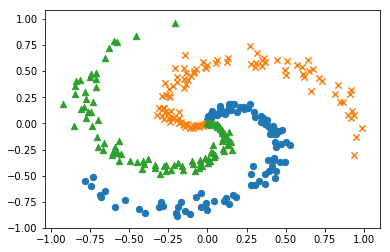

In [24]:
import matplotlib.pyplot as plt
x, t = load_spiral_data()
print('x', x.shape)
print('t', t.shape)

# データ点のプロット
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

非線形に分離しないといけない．

In [25]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        
        # 重みとバイアスの初期化
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)
        
        # レイヤの生成
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()
    
        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

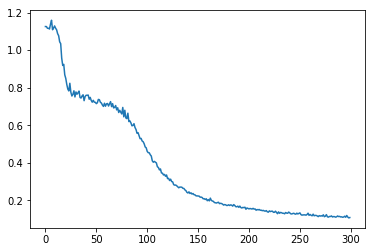

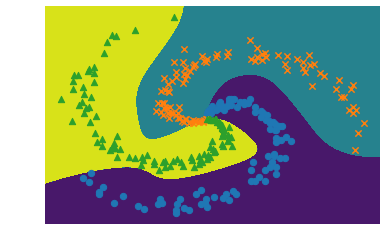

In [34]:
# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# データの読み込み，モデルとオプティマイザの生成
x, t = load_spiral_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # データのシャッフル
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]
    
    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]
    
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

    if (iters+1) % 10 == 0:
        avg_loss = total_loss / loss_count
        # print('| epoch %d | iter %d / %d | loss %.2f |' % (epoch + 1, iters + 1, max_iters, avg_loss))
        loss_list.append(avg_loss)
        total_loss, loss_count = 0, 0

# 学習の成果
plt.plot(range(max_epoch), loss_list)
plt.show()

# 境界領域のプロット
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# データ点のプロット
x, t = load_spiral_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [35]:
# permutationについて
# ランダムな0 ～ 10-1のインデックスのリストを生成
np.random.permutation(10)

array([3, 5, 0, 9, 7, 6, 1, 2, 4, 8])

以降，ニューラルネットワークの学習を実行する機会が多々ある．そのために必要なツールとして，common/trainer.pyを使う．  
以下に使用例を示す．

Trainerクラスのfitメソッドの引数  

|引数|説明|
|:--|:--|
|x|入力データ|
|t|教師ラベル|
|max_epoch(=10)|学習を行うエポック数(データセットを周回する回数)|
|batch_size(=32)|ミニバッチのサイズ|
|eval_interval(=20)|設定したイテレーション回数ごとに平均損失などを出力|
|max_grad(=None)|勾配の最大ノルム，勾配のノルムがこの値を超えた場合，勾配を小さくする|

| epoch 1 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 2 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 3 |  iter 1 / 10 | time 0[s] | loss 1.13
| epoch 4 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 5 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 6 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 7 |  iter 1 / 10 | time 0[s] | loss 1.14
| epoch 8 |  iter 1 / 10 | time 0[s] | loss 1.16
| epoch 9 |  iter 1 / 10 | time 0[s] | loss 1.11
| epoch 10 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 11 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 12 |  iter 1 / 10 | time 0[s] | loss 1.12
| epoch 13 |  iter 1 / 10 | time 0[s] | loss 1.10
| epoch 14 |  iter 1 / 10 | time 0[s] | loss 1.09
| epoch 15 |  iter 1 / 10 | time 0[s] | loss 1.08
| epoch 16 |  iter 1 / 10 | time 0[s] | loss 1.04
| epoch 17 |  iter 1 / 10 | time 0[s] | loss 1.03
| epoch 18 |  iter 1 / 10 | time 0[s] | loss 0.94
| epoch 19 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 20 |  iter 1 / 10 | time 0[s] | loss 0.92
| epoch 2

| epoch 180 |  iter 1 / 10 | time 0[s] | loss 0.19
| epoch 181 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 182 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 183 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 184 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 185 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 186 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 187 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 188 |  iter 1 / 10 | time 0[s] | loss 0.18
| epoch 189 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 190 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 191 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 192 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 193 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 194 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 195 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 196 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 197 |  iter 1 / 10 | time 0[s] | loss 0.16
| epoch 198 |  iter 1 / 10 | time 0[s] | loss 0.17
| epoch 199 |  iter 1 / 10 | ti

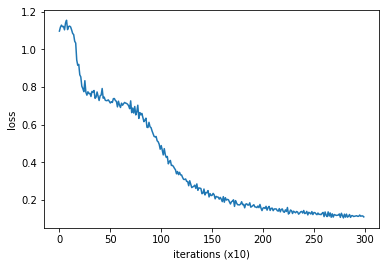

In [37]:
from common.optimizer import SGD
from common.trainer import Trainer
from dataset import spiral
from ch01.two_layer_net import TwoLayerNet

max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

trainer = Trainer(model, optimizer)
trainer.fit(x, t, max_epoch, batch_size, eval_interval=10)
trainer.plot()

## 計算の高速化
ビット精度とGPU

### ビット精度
Numpyの精度は標準で64ビット

In [38]:
a = np.random.randn(3)
a.dtype

dtype('float64')

しかし，32bitで十分なことが知られているので，優先的に32bitで計算をおこなっていく

In [39]:
b = np.random.randn(3).astype(np.float32)
print(b.dtype)

c = np.random.randn(3).astype('f')
print(c.dtype)

float32
float32


もっというと16bitで推論の精度はほとんど落ちないが，GPUの計算は基本32bitで行われるため，あまり恩恵を受けられない．  
学習した重みを保存する時，16bitに変換する．  
しかし最近では16bitをサポートするGPUもこのために増えてきた．  
GoogleのTPUと呼ばれる独自チップは8bit計算が可能

#### GPU(CuPy)
ディープラーニングにおける大量の積和演算は，GPUによって並列計算するのが早い．  
GPUを使った並列計算を行うには，cupyを用いる．  
NVIDIA製のGPUを使い，CUDAと呼ばれるGPU向け汎用並列コンピューティングプラットフォームをインストールする必要がある．  
cupyは，numpyとほぼ同じインタフェースを持つ．  

In [40]:
# import cupy as cp
import numpy as cp
x = cp.arange(6).reshape(2,3).astype('f')
print(x)
print(x.sum(axis=1))

[[0. 1. 2.]
 [3. 4. 5.]]
[ 3. 12.]


4章からはGPU計算が必要になってくる．  
CPUでは数時間かかるが，GPUなら数十分で終わる．  
common/config.GPUをTrueにすることでcupyによるGPU計算を実行できる．